In [1]:
import pickle as pkl
import random
import sys
import warnings
from collections import OrderedDict
from glob import glob
from pathlib import Path
from time import time
from typing import Callable, Dict, Optional, Tuple

import brevitas
import brevitas.nn as qnn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from brevitas import config
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from concrete.fhe.compilation import Configuration
from sklearn.metrics import top_k_accuracy_score
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

from concrete.ml.torch.compile import compile_brevitas_qat_model

warnings.filterwarnings("ignore", category=UserWarning)


from cifar_utils import (
    fhe_compatibility,
    get_dataloader,
    mapping_keys,
    plot_baseline,
    plot_dataset,
    torch_inference,
    train,
)

In [2]:
# class Flatten(torch.nn.Module):
#     def forward(self, x):
#         batch_size = x.shape[0]
#         return x.view(batch_size, -1)

# m = torch.diag(torch.full((92,92), 3.))
# class Diag(torch.nn.Module):
#     def forward(self, x):
#         print(x.shape, "Diag")
#         diag = torch.matmul(x, m)

#         print(diag.shape, "after Diag")
#         return torch.matmul(x, m)

In [3]:
input_size = 28

FEATURES_MAPS = [
    ("I",),
    # Layer 1: input_size, out_size, kernel_size=t[3], stride=t[4], padding=t[5], padding_mode="replicate")
    ("C", 1, 1, 3, 1, 1, "replicate"),
    ("R",),
]

# In the paper, we have 17 identity layers (frozen layers)
LINEAR_LAYERS = (
    [("L", input_size * input_size, 92), "R"] + [("L", 92, 92), ("R",)] * 17 + [("L", 92, 10)]
)

<!> Since MNIST is a relatively simple task, training a floating-point model and then fine-tuning the quantized model yields the same results as training the quantized model from scratch.

- If we train first the FP32, then assign the weights to the Brevitas model, and finally finetune it, we save like  10 epochs 

<!> That's why the following cell is disabled.

In [14]:
class Fp32MNIST(nn.Module):
    def __init__(self, output_size: int):
        super(Fp32MNIST, self).__init__()
        """ Torch model.

        Args:
            output_size (int): Number of classes.
        """
        self.output_size = output_size

        def make_layers(t):

            if t[0] == "C":
                return nn.Conv2d(t[1], t[2], kernel_size=t[3], stride=t[4], padding=t[5], padding_mode=t[6])
            elif t[0] == "L":
                return nn.Linear(in_features=t[1], out_features=t[2])
            elif t[0] == "R":
                return nn.ReLU()
            elif t[0] == "F":
                return nn.Flatten(1, -1)
            elif t[0] == "ID":

                return Diag()
            else:
                raise NameError(f"{t} not defined")

        self.features_maps = nn.Sequential(*[make_layers(t) for t in FEATURES_MAPS if t[0] != "I"])
        self.linears = nn.Sequential(*[make_layers(t) for t in LINEAR_LAYERS if t[0] != "I"])

    def forward(self, x):
        x = self.features_maps(x)
        x = nn.Flatten()(x)
        x = self.linears(x)
        return x

In [5]:
class QuantMNIST(nn.Module):
    def __init__(
        self,
        bit: int,
        output_size: int = 3,
        act_quant: brevitas.quant = Int8ActPerTensorFloat,
        weight_quant: brevitas.quant = Int8WeightPerTensorFloat,
    ):
        """A quantized network with Brevitas.

        Args:
            bit (int): Bit of quantization.
            output_size (int): Number of classes.
            act_quant (brevitas.quant): Quantization protocol of activations.
            weight_quant (brevitas.quant): Quantization protocol of the weights.

        """
        super(QuantMNIST, self).__init__()
        self.bit = bit

        def tuple2quantlayer(t):
            if t[0] == "R":
                return qnn.QuantReLU(return_quant_tensor=True, bit_width=bit, act_quant=act_quant)
            if t[0] == "C":
                return qnn.QuantConv2d(
                    t[1],
                    t[2],
                    kernel_size=t[3],
                    stride=t[4],
                    padding=t[5],
                    weight_bit_width=2,
                    weight_quant=weight_quant,
                    return_quant_tensor=True,
                )
            if t[0] == "L":
                return qnn.QuantLinear(
                    in_features=t[1],
                    out_features=t[2],
                    weight_bit_width=bit,
                    weight_quant=weight_quant,
                    bias=True,
                    return_quant_tensor=True,
                )
            if t[0] == "I":
                identity_quant = t[1] if len(t) == 2 else bit
                return qnn.QuantIdentity(
                    bit_width=identity_quant, act_quant=act_quant, return_quant_tensor=True
                )

        self.features_maps = nn.Sequential(
            *[tuple2quantlayer(t) for t in FEATURES_MAPS if t[0] != "I"]
        )

        # self.identity1 and self.identity2 are used to encapsulate the `torch.flatten`.
        self.identity1 = qnn.QuantIdentity(
            bit_width=bit, act_quant=act_quant, return_quant_tensor=True
        )

        self.identity2 = qnn.QuantIdentity(
            bit_width=bit, act_quant=act_quant, return_quant_tensor=True
        )

        self.linears = nn.Sequential(*[tuple2quantlayer(t) for t in LINEAR_LAYERS if t[0] != "I"])

    def forward(self, x):
        x = self.features_maps(x)
        x = self.identity1(x)
        # As `torch.flatten` is a PyTorch layer, you must place it between two `QuantIdentity`
        # layers to ensure that all intermediate values of the network are properly quantized.
        x = torch.flatten(x, 1)
        # Replace `x.view(x.shape[0], -1)` by `torch.flatten(x, 1)` which is an equivalent
        # But is compatible with Concrete ML.
        x = self.identity2(x)
        x = self.linears(x)
        return x.value

Train the model

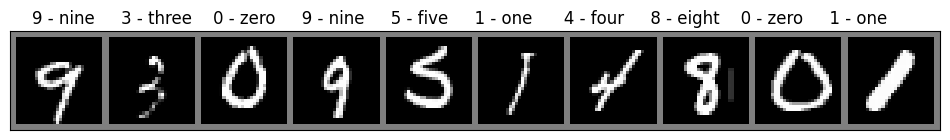

In [6]:
param = {
    "output_size": 10,
    "batch_size": 64,
    "dataset_name": "MNIST",
    "dataset": datasets.MNIST,
    "dir": "./checkpoints/MNIST_V747",
    "training": "fp32",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "seed": 42,
}

device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader, test_loader = get_dataloader(param=param)

plot_dataset(test_loader, param)

In [7]:
for x, y in train_loader:
    break

x.shape

torch.Size([64, 1, 28, 28])

In [15]:
# Instantiation of the custom VGG-11 network.

fp32_mnist = Fp32MNIST(param['output_size']).to(device)

# # We freeze all the layers.
for n, p in list(fp32_mnist.named_parameters())[4: -2]:
        p.requires_grad = False
        #print(n, p.requires_grad)

# # We freeze all the layers.
for n, p in fp32_mnist.named_parameters():
        print(n, p.requires_grad)

features_maps.0.weight True
features_maps.0.bias True
linears.0.weight True
linears.0.bias True
linears.2.weight False
linears.2.bias False
linears.4.weight False
linears.4.bias False
linears.6.weight False
linears.6.bias False
linears.8.weight False
linears.8.bias False
linears.10.weight False
linears.10.bias False
linears.12.weight False
linears.12.bias False
linears.14.weight False
linears.14.bias False
linears.16.weight False
linears.16.bias False
linears.18.weight False
linears.18.bias False
linears.20.weight False
linears.20.bias False
linears.22.weight False
linears.22.bias False
linears.24.weight False
linears.24.bias False
linears.26.weight False
linears.26.bias False
linears.28.weight False
linears.28.bias False
linears.30.weight False
linears.30.bias False
linears.32.weight False
linears.32.bias False
linears.34.weight False
linears.34.bias False
linears.36.weight True
linears.36.bias True


In [ ]:
# # # We freeze all the layers.
# # for n, p in fp32_mnist.named_parameters():
# #         print(n, p.requires_grad)

In [22]:
# len(list(fp32_mnist.parameters())[2:-1]), len(list(fp32_mnist.parameters()))

In [26]:
# # We freeze all the layers.

quant_mnist = QuantMNIST(bit=6, output_size=param["output_size"]).to("cpu")

for n, p in list(quant_mnist.named_parameters())[7: -2]:
        p.requires_grad = False
        #print(n, p.requires_grad)

# for n, p in list(quant_mnist.named_parameters()):
#         print(n, p.requires_grad)

|x| -> 2 relus 
faster absolute value ? 

In [27]:
if True:
    param["training"] = "quant"
    param["epochs"] = 40
    param["lr"] = 0.6
    param["milestones"] = [25]
    param["gamma"] = 0.1

    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 1.0226 VS Test loss = 0.4957 - Accuracy train: 0.6490 VS Accuracy test: 0.8512
Epoch  1: Train loss = 0.5312 VS Test loss = 0.4840 - Accuracy train: 0.8423 VS Accuracy test: 0.8583
Epoch  2: Train loss = 0.4839 VS Test loss = 0.4608 - Accuracy train: 0.8578 VS Accuracy test: 0.8667
Epoch  3: Train loss = 0.4463 VS Test loss = 0.4447 - Accuracy train: 0.8704 VS Accuracy test: 0.8733
Epoch  4: Train loss = 0.4159 VS Test loss = 0.4048 - Accuracy train: 0.8811 VS Accuracy test: 0.8832
 12%|█▎        | 5/40 [02:51<19:47, 33.93s/it]

In [11]:
if False:
    param["training"] = "quant"
    param["epochs"] = 20
    param["lr"] = 0.1
    param["milestones"] = [60]
    param["gamma"] = 0.1

    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 1.1537 VS Test loss = 0.5069 - Accuracy train: 0.6001 VS Accuracy test: 0.8585
Epoch  1: Train loss = 0.4118 VS Test loss = 0.3476 - Accuracy train: 0.8816 VS Accuracy test: 0.9021
Epoch  2: Train loss = 0.3048 VS Test loss = 0.2766 - Accuracy train: 0.9132 VS Accuracy test: 0.9209
Epoch  3: Train loss = 0.2596 VS Test loss = 0.2674 - Accuracy train: 0.9248 VS Accuracy test: 0.9236
Epoch  4: Train loss = 0.2328 VS Test loss = 0.2431 - Accuracy train: 0.9326 VS Accuracy test: 0.9287
Epoch  5: Train loss = 0.2086 VS Test loss = 0.2351 - Accuracy train: 0.9403 VS Accuracy test: 0.9336
Epoch  6: Train loss = 0.1943 VS Test loss = 0.2230 - Accuracy train: 0.9439 VS Accuracy test: 0.9358
Epoch  7: Train loss = 0.1791 VS Test loss = 0.2203 - Accuracy train: 0.9484 VS Accuracy test: 0.9372
Epoch  8: Train loss = 0.1703 VS Test loss = 0.2270 - Accuracy train: 0.9515 VS Accuracy test: 0.9375
Epoch  9: Train loss = 0.1604 VS Test loss = 0.2156 - Accuracy train: 0.9546 VS Ac

In [20]:
path = "./checkpoints/MNIST_V727/quant/MNIST_quant_state_dict.pt"

checkpoint = torch.load(path, map_location=device)

quant_mnist = QuantMNIST(bit=6, output_size=param["output_size"]).to("cpu")

quant_mnist.load_state_dict(checkpoint)

# We freeze all the layers.
for i, (n, p) in enumerate(list(quant_mnist.named_parameters())[7:-2]):
    p.requires_grad = False


acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)
param["accuracy_test"].append(acc_before_ft)
print(f"Top 1 accuracy before fine-tuning = {acc_before_ft * 100:.4f}%")

Top 1 accuracy before fine-tuning = 94.1206%


In [39]:
data_calibration, _ = next(iter(train_loader))


def fhe_compatibility(model: Callable, data: DataLoader, rounding=5, mlir=False) -> Callable:
    """Test if the model is FHE-compatible.

    Args:
        model (Callable): The Brevitas model.
        data (DataLoader): The data loader.

    Returns:
        Callable: Quantized model.
    """

    qmodel = compile_brevitas_qat_model(
        model.to("cpu"),
        # Training
        torch_inputset=data,
        show_mlir=mlir,
        output_onnx_file="test.onnx",
        rounding_threshold_bits=rounding,
    )

    return qmodel


qmodel = fhe_compatibility(quant_mnist, data_calibration, mlir=False, rounding=4)

print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}")

Maximum bit-width in the circuit: 17


In [42]:
data_calibration, _ = next(iter(train_loader))

history = {}

for thresold in range(quant_mnist.bit - 1, 1, -1):
    history_yhats, history_timing = [], []

    for data, labels in tqdm(test_loader):

        data, labels = data.detach().cpu().numpy(), labels.detach().cpu().numpy()

        history[thresold] = []
        try:

            qmodel = compile_brevitas_qat_model(
                quant_mnist.to("cpu"),
                torch_inputset=data_calibration,
                rounding_threshold_bits=thresold,
            )
            start_time = time()
            predictions = qmodel.forward(data, fhe="simulate")
            end_time = ((time() - start_time) / 60.0) / data.shape[0]

            history_yhats.extend(predictions.argmax(1) == labels)
            history_timing.append(end_time)
        except:
            print(thresold)

            history_yhats.extend(None)
            history_timing.append(None)

    history[thresold].append([history_yhats, history_timing])

100%|██████████| 156/156 [14:42<00:00,  5.65s/it]


In [73]:
for threshold in history.keys():
    print(
        f"{threshold=}: accuracy = {np.mean(history[threshold][0][0])}, {np.mean(history[threshold][0][1])}"
    )

5: accuracy = 0.6098758012820513, 0.00021265146330508406
4: accuracy = 0.23888221153846154, 0.00021482940532394453
3: accuracy = 0.11828926282051282, 0.0002150003475925097
2: accuracy = 0.10586939102564102, 0.00021364874461204068
